## EXERCISE 4

We want to study the performances of an RBM, and, by looking at its learned weights and biases, better understand the correlations in the data (from file x_RBM_2024_exercise.dat, N=104 configurations with L=10 bits). Use an RBM with M=3 hidden units.

| Name | Surname | ID Number |
|------|---------|---------------------|
| Lucrezia | Rossi | 2122164 |
| Lorenzo | Calandra Buonaura | 2107761 |
| Andrea | Turci | 2106724 |

In [1]:
import numpy as np
from numpy import exp, sqrt, abs
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
plt.rcParams['font.size'] = 13

from IPython.display import display_html 
import pandas as pd

In [2]:
dname = "DATA"; fname = dname + '/x_RBM_2024_exercise.dat'

v = np.loadtxt(fname, delimiter = " ", dtype = int)
N = len(v)
L = len(v[1])
# store in v0, because later we will shuffle v
v0 = np.copy(v)
print(f'each of N={N} data has L={L} digits')
#SPINS = True
SPINS = False

if SPINS:
    # sigmoid takes into account energy difference =2
    GAP=2
    # convert 0,1 -> -1,1
    v = 2*v - 1
    vmin=-1
else:
    GAP=1
    vmin=0

print(f'each of N={N} data has L={L} digits')

for i in range(min(12,N)):
    if SPINS: print(v0[i],"\n->",v[i])
    else: print(v[i])
print('...')

each of N=10000 data has L=10 digits
each of N=10000 data has L=10 digits
[0 0 1 1 0 0 0 0 1 1]
[0 0 0 1 0 0 0 1 0 0]
[1 0 0 0 1 0 1 0 0 0]
[0 1 1 1 0 1 0 1 0 0]
[1 1 1 0 1 1 1 1 0 0]
[0 1 0 0 1 1 1 0 0 0]
[1 0 1 0 0 0 1 1 1 1]
[1 0 1 1 0 1 1 0 0 0]
[1 0 1 0 0 0 0 1 1 1]
[1 1 0 0 1 1 0 0 0 0]
[0 1 0 1 0 0 0 0 1 1]
[1 1 0 1 1 1 1 1 0 0]
...


In [3]:
def is_one(cell_value):
    color0 = 'background-color: gray; color: white'
    color1 = 'background-color: white;'
    if type(cell_value) in [float, int]:
        if cell_value == 1:
            return color1
    return color0

N1=12
df0 = pd.DataFrame(v[:N1])
df0s = df0.style.set_table_attributes("style='display:inline'")
df0s.map(is_one)
sty = [dict(selector="caption",props=[("font-size", "150%")])]
df0s.set_caption('Original').set_table_styles(sty)

display_html(df0s._repr_html_(), raw=True)

,0,1,2,3,4,5,6,7,8,9
0,0,0,1,1,0,0,0,0,1,1
1,0,0,0,1,0,0,0,1,0,0
2,1,0,0,0,1,0,1,0,0,0
3,0,1,1,1,0,1,0,1,0,0
4,1,1,1,0,1,1,1,1,0,0
5,0,1,0,0,1,1,1,0,0,0
6,1,0,1,0,0,0,1,1,1,1
7,1,0,1,1,0,1,1,0,0,0
8,1,0,1,0,0,0,0,1,1,1
9,1,1,0,0,1,1,0,0,0,0


In [4]:
# RBM, nr of hidden units
M = 3
# range of each initial weight
sigma = sqrt(4. / float(L + M))
# random seed for reproducibility
np.random.seed(12345)
# initial weights from a Normal distr. (see literature, e.g. page 98 of Mehta's review)
w = sigma * np.random.randn(L,M)
a = sigma * np.random.randn(L)
b = np.zeros(M)
print("w=",w);print("a=",a);print("b=",b)
w0,a0,b0=np.copy(w),np.copy(a),np.copy(b)

w= [[-1.13551379e-01  2.65669964e-01 -2.88132757e-01]
 [-3.08263709e-01  1.09041887e+00  7.72922489e-01]
 [ 5.15360175e-02  1.56284646e-01  4.26576969e-01]
 [ 6.91397593e-01  5.58688134e-01 -7.19014104e-01]
 [ 1.52537913e-01  1.26978019e-01  7.50463234e-01]
 [ 4.91702529e-01 -1.11030861e+00 -2.06261128e-01]
 [ 9.25808667e-01 -2.43274719e-01 -2.99394686e-01]
 [ 2.64583679e-01  1.80218983e+00 -5.66475108e-01]
 [-3.20110440e-01  6.88500960e-02  1.67859802e-01]
 [ 2.90536469e-01  5.21572266e-04  7.45411556e-01]]
a= [-0.39580299 -0.46104103 -1.31476796 -1.03216437 -0.4774623   0.3107127
 -0.70221411  0.06646813 -0.58993056  0.18465011]
b= [0. 0. 0.]


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 1]


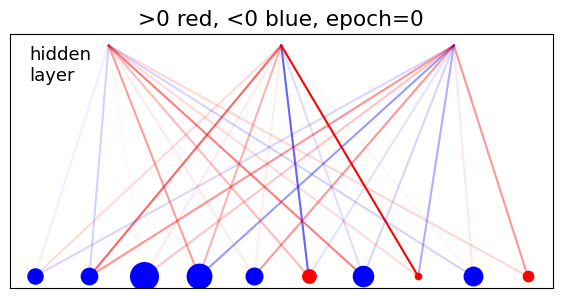

In [5]:
def create_coord(np,x0,f=1.0):
    x=[x0] * np
    print(x)
    y=list(range(np))
    for i in range(np):
        y[i] = f*(y[i]/(np-1.) - 0.5)
    return (x,y)
(x1,y1)=create_coord(L,0)
(x2,y2)=create_coord(M,1,f=0.7)

def mycolor(val):
    if val>0: return 'red'
    elif val<0: return 'blue'
    else: return 'black'

def plotgraph_vert(epoch=0):
    A=2./w.max()
    for i in range(L):
        for j in range(M):
            ex, ey, col = (x1[i],x2[j]),(y1[i],y2[j]),mycolor(w[i][j])
            plt.plot(ex, ey, col, zorder=1, lw=A*abs(w[i][j]))
    # Scatter plot on top of lines
    
    A=300./(a.max()+b.max())
    
    for i in range(L):
        plt.scatter(x1[i], y1[i], s=A*abs(a[i]), zorder=2, c=mycolor(a[i]))

    for j in range(M):
        plt.scatter(x2[j], y2[j], s=A*abs(b[j]), zorder=2, c=mycolor(b[j]), marker="s")
    plt.figaspect(1)
    plt.title(f'>0 red, <0 blue, epoch={epoch}')
    plt.show()
    
def plotgraph(epoch=0):
    fig, ax = plt.subplots(1,1 , figsize=(7, 3.3))
    ax.tick_params(left=False,bottom=False)
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    
    A=1./max(w.max(),-w.min())
    for i in range(L):
        for j in range(M):
            ex, ey, col = (y1[i],y2[j]),(x1[i],x2[j]),mycolor(w[i][j])
            ax.plot(ex, ey, col, zorder=1, alpha=A*abs(w[i][j]))
    # Scatter plot on top of lines
    #A=300./(a.max()+b.max())
    A=300.
    for i in range(L):
        ax.scatter(y1[i],x1[i], s=A*abs(a[i]), zorder=2, c=mycolor(a[i]))
    for j in range(M):
        ax.scatter(y2[j], x2[j], s=min(300,A*abs(b[j])), zorder=2, c=mycolor(b[j]), marker="s")
    ax.set_title(f'>0 red, <0 blue, epoch={epoch}')
    ax.text(-0.51,0.85,"hidden\nlayer")
    plt.show()
                  
plotgraph()

In [6]:
# eq(213) page 97, activation via sigmoid
# taking into account energy gap DE=2 for "spin" variables (-1,1)
def activate(v_in,wei,bias,DE,info=False):
    act = np.dot(v_in, wei) + bias
    n = np.shape(act)
    prob = 1. / (1. + exp(-DE*act))
    v_out = np.full(n, vmin, dtype=int) # a list on -1's or 0's
    v_out[np.random.random_sample(n) < prob] = 1 # activate the 1's with probability prob
    if info:
        print('input=', v_in)
        print('act=',act)
        print('prob=',prob)
        print('output=',v_out)
    return v_out

k = 0
activate(v[k],w,b,GAP,info=True)

input= [0 0 1 1 0 0 0 0 1 1]
act= [0.71335964 0.78434445 0.62083422]
prob= [0.67114309 0.68661569 0.65040826]
output= [1 1 0]


array([1, 1, 0])

1.
Increase the number of contrastive divergence steps from n=1 to n=5.

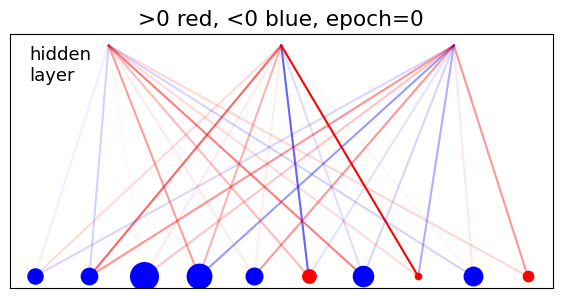

----------- epoch = 0   k= 499   m= 500
dw = [[ 0.106  0.114  0.05 ]
 [-0.066 -0.146 -0.146]
 [ 0.2    0.156  0.078]
 [ 0.112  0.068  0.052]
 [-0.01  -0.072 -0.076]
 [ 0.098  0.03  -0.032]
 [ 0.072 -0.024 -0.03 ]
 [-0.13  -0.24  -0.242]
 [ 0.144  0.13   0.082]
 [-0.14  -0.18  -0.156]]
da = [ 0.156 -0.136  0.21   0.122 -0.03   0.06   0.046 -0.25   0.188 -0.184]
db = [ 0.058 -0.066 -0.104]
----------- epoch = 1   k= 499   m= 500
dw = [[ 0.00594059  0.00594059  0.01386139]
 [-0.06336634 -0.06336634 -0.04158416]
 [-0.00792079  0.0019802  -0.04554455]
 [-0.09306931 -0.07524752 -0.04752475]
 [ 0.         -0.0019802   0.03960396]
 [ 0.04158416  0.          0.04356436]
 [-0.02376238 -0.05742574 -0.04950495]
 [-0.01980198 -0.01188119 -0.05742574]
 [-0.05346535 -0.02772277  0.        ]
 [-0.05544554 -0.00792079 -0.04752475]]
da = [ 0.02376238 -0.04356436  0.03366337 -0.06930693  0.05346535  0.05940594
 -0.02178218  0.00792079  0.0019802  -0.02772277]
db = [-0.03762376 -0.03564356 -0.03564356]


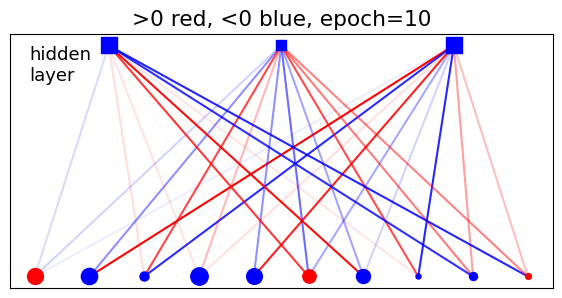

l_rate =  0.9090909090909092


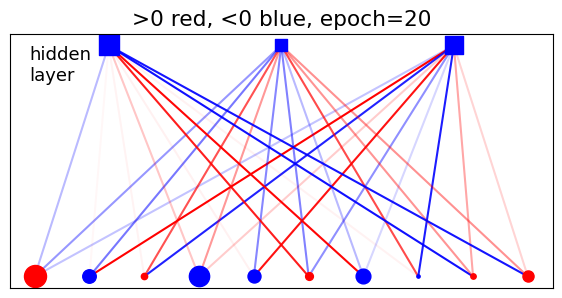

l_rate =  0.8333333333333337


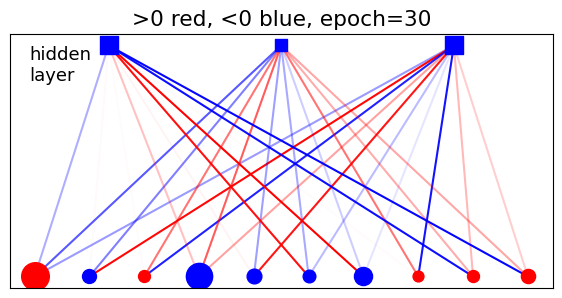

l_rate =  0.7692307692307697


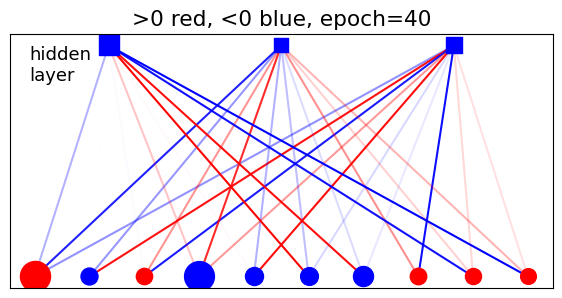

l_rate =  0.7142857142857149


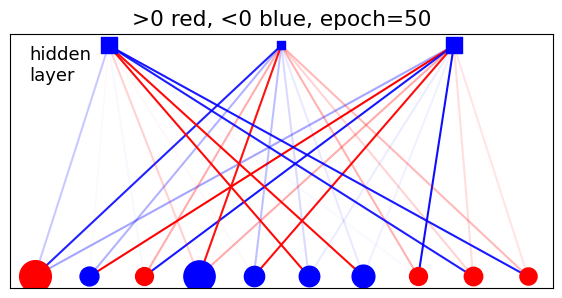

l_rate =  0.6666666666666671


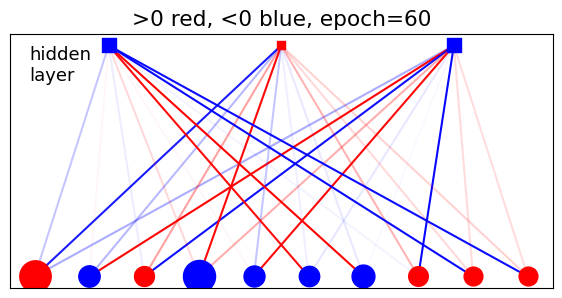

l_rate =  0.6250000000000006


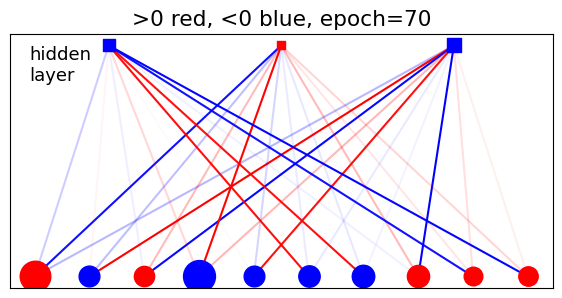

l_rate =  0.5882352941176475


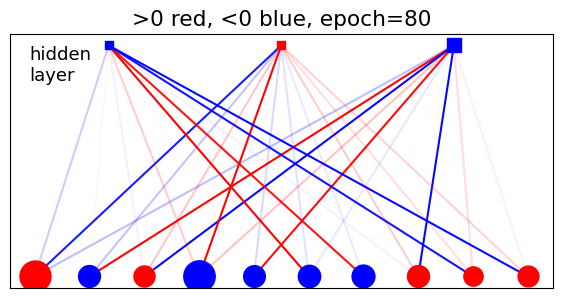

l_rate =  0.555555555555556


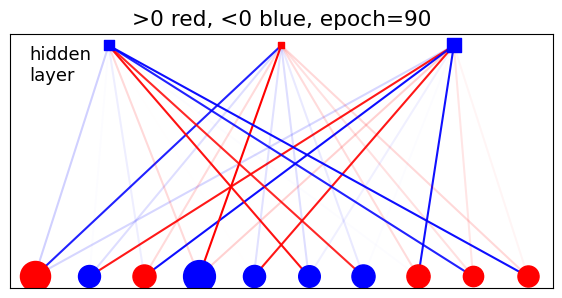

l_rate =  0.5263157894736847


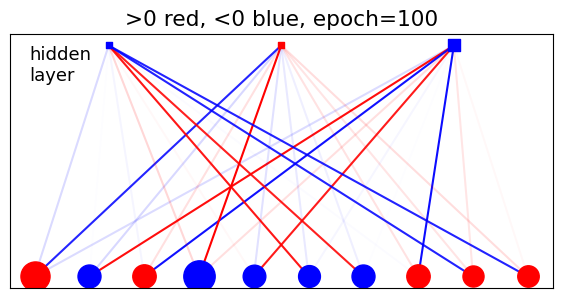

l_rate =  0.5000000000000009


In [7]:
# random seed for reproducibility
np.random.seed(12345)

plotgraph(0)

# learning rate
l_rate = 1.0

# minibatch
mini, m = 500, 0

# number of CD steps
n_steps = 5

# train model
print('===================================================')
for epoch in range(100):
    # aggregate normalization of batch statistics and learning rate in l_rate_m
    l_rate_m = l_rate / mini
    for k in range(N):
        if m == 0:
            # initialize averages in miniblock
            v_data, v_model = np.zeros(L), np.zeros(L)
            h_data, h_model = np.zeros(M), np.zeros(M)
            vh_data, vh_model = np.zeros((L, M)), np.zeros((L, M))
        
        # Perform CD steps
        for step in range(n_steps):
            # positive CD phase: generating h 
            h = activate(v[k], w, b, GAP)
            # negative CD phase: generating fantasy vf
            vf = activate(h, w.T, a, GAP)
            # one more positive CD phase: generating fantasy h from fantasy vf 
            hf = activate(vf, w, b, GAP)
        
        v_data += v[k]
        v_model += vf
        h_data += h
        h_model += hf
        vh_data += np.outer(v[k].T, h)
        vh_model += np.outer(vf.T, hf)
    
        m += 1
        # minibatch
        if m == mini:
            # gradient of the likelihood: follow it along its positive direction
            # with a "vanilla" SGD
            dw = l_rate_m * (vh_data - vh_model)
            da = l_rate_m * (v_data - v_model)
            db = l_rate_m * (h_data - h_model)
            if epoch <= 1 and k <= mini:
                print('----------- epoch =', epoch, '  k=', k, '  m=', m)
                print('dw =', dw)
                print('da =', da)
                print('db =', db)
            # basic step of vanilla gradient descent, from eq.(211)
            w = w + dw
            a = a + da
            b = b + db
            m = 0
    
    # randomize the order of input data
    np.random.shuffle(v)
    # decrease the learning rate (here as a power law)
    l_rate = l_rate / (0.01 * l_rate + 1)
    if epoch % 10 == 9:
        plotgraph(epoch + 1)
        print('l_rate = ', l_rate)

### Answer 1:

2.
Compute the log-likelihood L  during the training, at every epoch, or every minibatch update if it 
reaches a maximum already in the first epoch. Use “t” as an index of this “time”, indicating the unit 
in the figures.

----------- epoch = 0   t= 499   m= 500
dw = [[-0.0007984   0.00279441 -0.00359281]
 [-0.00958084 -0.00439122 -0.00638723]
 [ 0.0007984  -0.00159681  0.00319361]
 [-0.00518962  0.0007984   0.00399202]
 [-0.0007984   0.0007984   0.00279441]
 [ 0.00399202  0.00359281 -0.00279441]
 [-0.00319361 -0.00518962 -0.00439122]
 [-0.00359281 -0.00558882  0.00199601]
 [ 0.00159681  0.00598802 -0.0003992 ]
 [-0.00518962  0.00359281 -0.00279441]]
da = [-0.00518962 -0.00838323  0.00479042 -0.0003992   0.00159681  0.00399202
 -0.00638723 -0.00239521  0.00479042  0.00199601]
db = [-0.00279441  0.00359281 -0.00359281]
----------- epoch = 1   t= 499   m= 500
dw = [[-0.01075697  0.00039841  0.        ]
 [-0.00318725  0.00119522  0.00159363]
 [ 0.00119522  0.01195219  0.00836653]
 [ 0.00318725  0.00996016  0.00438247]
 [-0.00557769 -0.00039841 -0.00557769]
 [ 0.00119522  0.00876494  0.00557769]
 [-0.00677291  0.00119522  0.00239044]
 [-0.00478088  0.00278884  0.00278884]
 [ 0.          0.00517928  0.0071713

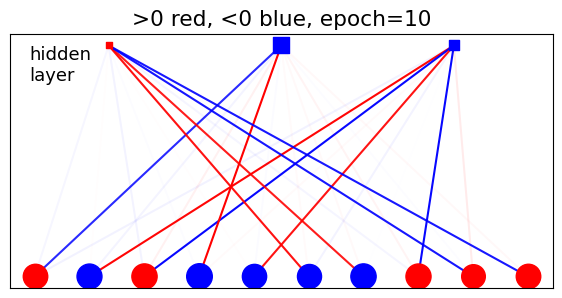

l_rate =  0.19569471624266144
Log-likelihood at epoch 10: 12.63591932568848


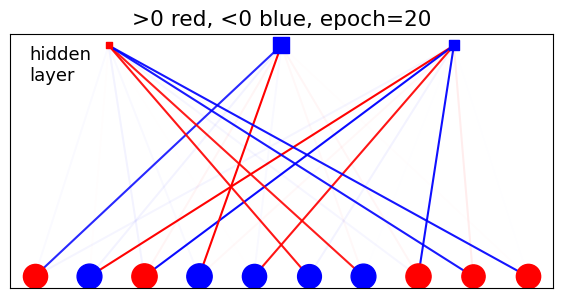

l_rate =  0.1919385796545105
Log-likelihood at epoch 20: 12.704730035432554


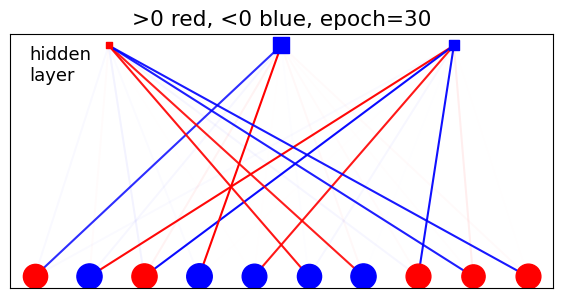

l_rate =  0.18832391713747632
Log-likelihood at epoch 30: 12.625409238963915


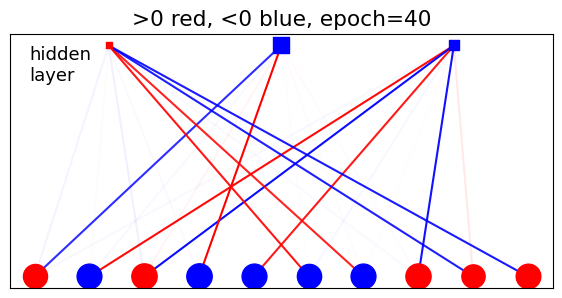

l_rate =  0.18484288354898323
Log-likelihood at epoch 40: 12.636333253714922


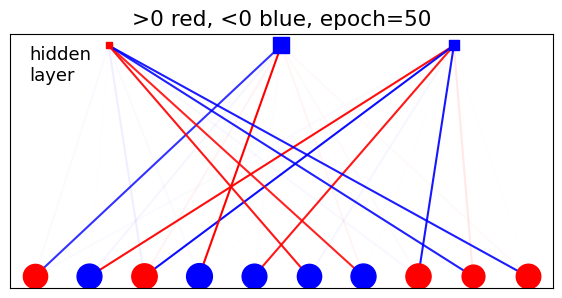

l_rate =  0.1814882032667875
Log-likelihood at epoch 50: 12.696248828747278


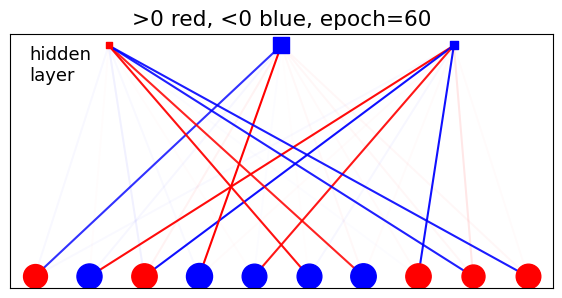

l_rate =  0.1782531194295899
Log-likelihood at epoch 60: 12.724527493115028


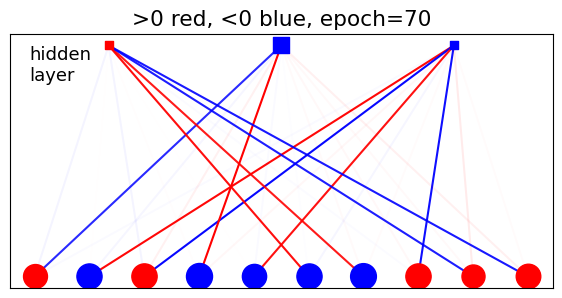

l_rate =  0.17513134851138343
Log-likelihood at epoch 70: 12.744797570537347


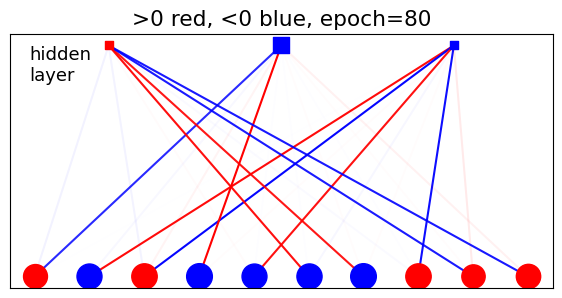

l_rate =  0.17211703958691899
Log-likelihood at epoch 80: 12.627320563580328


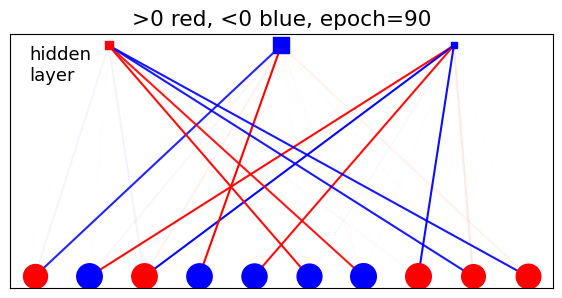

l_rate =  0.16920473773265646
Log-likelihood at epoch 90: 12.690978830297107


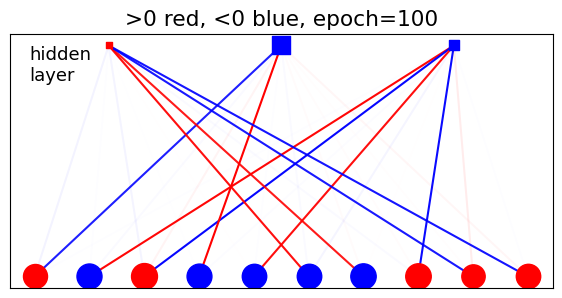

l_rate =  0.16638935108153066
Log-likelihood at epoch 100: 12.626706622118672


In [15]:
# Define a function to compute the log-likelihood
def log_likelihood(v, w, a, b):
    h = activate(v, w, b, GAP)  # Compute hidden states
    energy = -np.dot(v, a) - np.dot(h, b) - np.sum(np.dot(v, w) * h, axis=1)
    return np.log(np.sum(np.exp(-energy)))

# Initialize a list to store log-likelihood values
log_likelihoods = []

# Train model
print('===================================================')
for epoch in range(100):
    # aggregate normalization of batch statistics and learning rate in l_rate_m
    l_rate_m = l_rate / mini
    for t in range(N):  # Iterate over each data point
        if m == 0:
            # initialize averages in miniblock
            v_data, v_model = np.zeros(L), np.zeros(L)
            h_data, h_model = np.zeros(M), np.zeros(M)
            vh_data, vh_model = np.zeros((L, M)), np.zeros((L, M))
        
        # Perform CD steps
        for step in range(n_steps):
            # positive CD phase: generating h 
            h = activate(v[t], w, b, GAP)
            # negative CD phase: generating fantasy vf
            vf = activate(h, w.T, a, GAP)
            # one more positive CD phase: generating fantasy h from fantasy vf 
            hf = activate(vf, w, b, GAP)
        
        v_data += v[t]
        v_model += vf
        h_data += h
        h_model += hf
        vh_data += np.outer(v[t].T, h)
        vh_model += np.outer(vf.T, hf)
    
        m += 1
        # minibatch
        if m == mini:
            # gradient of the likelihood: follow it along its positive direction
            # with a "vanilla" SGD
            dw = l_rate_m * (vh_data - vh_model)
            da = l_rate_m * (v_data - v_model)
            db = l_rate_m * (h_data - h_model)
            if epoch <= 1 and t <= mini:
                print('----------- epoch =', epoch, '  t=', t, '  m=', m)
                print('dw =', dw)
                print('da =', da)
                print('db =', db)
            # basic step of vanilla gradient descent, from eq.(211)
            w = w + dw
            a = a + da
            b = b + db
            m = 0
    
    # randomize the order of input data
    np.random.shuffle(v)
    # decrease the learning rate (here as a power law)
    l_rate = l_rate / (0.01 * l_rate + 1)
    
    # Compute log-likelihood and store it
    ll = log_likelihood(v, w, a, b)
    log_likelihoods.append(ll)
    
    if epoch % 10 == 9:
        plotgraph(epoch + 1)
        print('l_rate = ', l_rate)
        print('Log-likelihood at epoch {}: {}'.format(epoch + 1, ll))

### Answer 2:

5.
Try RBMs with different numbers of hidden units: M=1, 2, 3 (done above), 4, 5, and 6.

### Answer 5:

3.
for M=3, plot L  as a function of “t”, comparing the two contrastive divergence cases (n=1 and 
n=5). Then, for n=1, plot L  as a function of “t”, comparing the two cases with different M.